# Imports

In [1]:
#!pip install tensorflow ipympl matplotlib tf2onnx seaborn joblib
import os
import pandas as pd
from scipy.integrate import cumulative_trapezoid
from scipy.stats import qmc
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib #to save Scalers
from sklearn.metrics import mean_squared_error
import seaborn as sns
from keras import Input
from keras.layers import Dense, Rescaling
from keras.optimizers import Adam
from keras.models import load_model, Sequential
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.backend import clear_session
import tf2onnx

from src._utils.utils import load_yaml_file
from src.models import PinnModel, CombinedLoss, CustomWeightLog
PHYSICS_PARAMS = load_yaml_file("src/config.yml")["PHYSICS_PARAMS"]

2025-07-05 16:25:20.231170: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-05 16:25:20.239949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751729120.252555 1924514 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751729120.256440 1924514 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751729120.264427 1924514 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Helper funcs

In [2]:
def comparison_plot(t: np.ndarray, true_data: np.ndarray,
                     pred_data: list[tuple[np.ndarray, str]], suptitle: str,
                     meas_data: np.ndarray = None):
    '''
    true_data: contains acc, vel (in m/s), and pos in (t, 3) shape
    '''
    # Plot for acceleration:
    plt.figure()
    plt.plot(t, true_data[:, 0], label="True Acceleration", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 0], '--', label=label, linewidth=2)
    if meas_data is not None:
        plt.scatter(t, meas_data, label="Measured acceleration points", s=7, c='red')
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("Acceleration")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot for velocity:
    plt.figure()
    plt.plot(t, true_data[:, 1]*3.6, label="True Velocity", linewidth=2) #conversion from m/s to km/h
    for data, label in pred_data:
        plt.plot(t, data[:, 1]*3.6, '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot for position
    plt.figure()
    plt.plot(t, true_data[:, 2], label="True Position", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 2], '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history, es_start_epoch):
    loss = history["loss"]
    val_loss = history["val_loss"]
    best_epoch = es_start_epoch + np.argmin(val_loss[es_start_epoch:]) + 1

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss, label="Training Loss")
    plt.plot(range(1, len(loss) + 1), val_loss, label="Validation Loss (against ground truth)")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

    #add a marker for the early stopping epoch
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Restored')
    plt.text(best_epoch, val_loss[best_epoch - 1], f'({best_epoch}, {val_loss[best_epoch - 1]:.5e})',
             color='b', fontsize=12)

    plt.legend()
    plt.show()

def evaluate_results(model, X, true_data, dt):
    v = np.zeros_like(X[:, 0]) #first feature is t
    x = np.zeros_like(X[:, 0])

    pred_a = model.predict(X, verbose=0)

    v = cumulative_trapezoid(pred_a.flatten(), dx=dt, initial=0)
    v += true_data[0,1]
    x = cumulative_trapezoid(v, dx=dt, initial=0)
    x += true_data[0,2]

    mse_a = mean_squared_error(true_data[:, 0], pred_a)
    mse_v = mean_squared_error(true_data[:, 1], v)
    mse_x = mean_squared_error(true_data[:, 2], x)

    v = v.reshape(-1, 1)
    x = x.reshape(-1, 1)

    pred_data = np.hstack((pred_a, v, x))

    print(f"MSE/RMSE for acceleration: {mse_a:.5e}, {np.sqrt(mse_a):.5e}")
    print(f"MSE/RMSE for velocity: {mse_v:.5e}, {np.sqrt(mse_v):.5e}")
    print(f"MSE/RMSE for position: {mse_x:.5e}, {np.sqrt(mse_x):.5e}")

    return pred_data

# Prepping data

## DEFINE HERE THE TRAINING SETUP

In [3]:
traj_id = ["udds", "hwycol", "nycccol"] #* CHANGE HERE TRAINING DATA
dataframes = []
for traj in traj_id:
    dataframes.append(pd.read_csv("data/driving_cycles/CACC_" + traj + ".csv"))
    df = pd.concat(dataframes)
train_ratio = .7
dataframes_str = "_".join(traj_id)
preliminary_model_name = f"FC_noWindow_{dataframes_str}_{int(train_ratio*100)}%" #name to use for saves
print(preliminary_model_name)
df.head()

FC_noWindow_udds_hwycol_nycccol_70%


,t,fv0_x,fv0_v_noise,fv0_v,fv0_u,fv0_a_noise,fv0_a,lv_x,lv_v_noise,lv_v,d_fv0_lv_noise,d_fv0_lv,d*_fv0_lv
0,0.0,-20.00000,-0.029503,0.0000,4.477721,4.190644,4.208,0.000000e+00,0.010140,0.000000e+00,20.089231,20.00000,2.0000
1,0.1,-19.97896,0.412804,0.4208,4.478601,4.203216,4.208,1.010206e-17,0.035353,2.020411e-16,20.012920,19.97896,2.4208
2,0.2,-19.91584,0.828050,0.8416,4.479590,4.223206,4.208,3.816332e-17,0.006467,3.591842e-16,19.944470,19.91584,2.8416
3,0.3,-19.81064,1.264956,1.2624,4.480690,4.203192,4.208,7.969400e-17,0.011232,4.714293e-16,19.807995,19.81064,3.2624
4,0.4,-19.66336,1.681171,1.6832,4.481898,4.213076,4.208,1.302043e-16,0.003388,5.387764e-16,19.672709,19.66336,3.6832


dt=0.1
Number of training points:
(19124, 1)
Number of validation points:
(8196, 1)


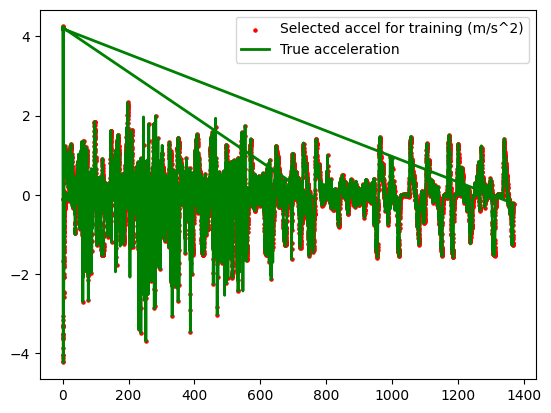

ScalerY: 
scale=[0.60080466], min=[-0.02397115]
ScalerX: 
scale=[0.00073051 0.11873608 0.03722332], min=[0.         0.46477229 0.00317806]


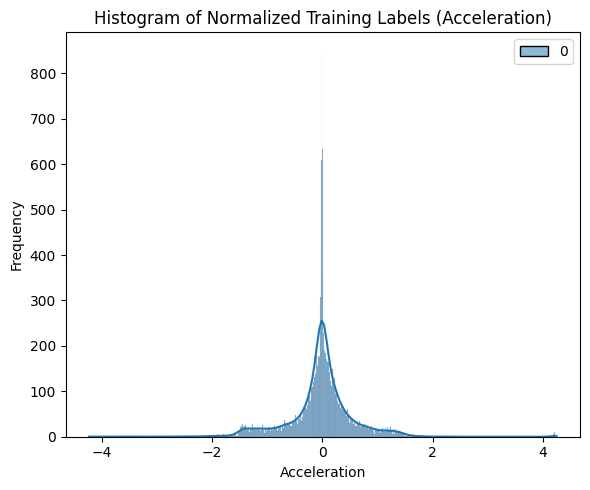

In [ ]:
X = df[["t", "fv0_u", "fv0_v_noise"]].to_numpy()
n_features = X.shape[1]
t = X[:, 0]
dt = t[1] - t[0]
print(f"dt={dt}")
Y = df[["fv0_a_noise"]].to_numpy()  #NN predicts instantaneous acceleration
y0 = Y[0]

Y_train, Y_val, X_train, X_val = train_test_split(Y, X, train_size=train_ratio, random_state=31)
print("Number of training points:")
print(Y_train.shape)
print("Number of validation points:")
print(Y_val.shape)

#Visualize training data provided to model:
mask = np.isin(Y, Y_train)
Y_mask = Y.copy()
Y_mask[~mask] = np.nan
plt.scatter(t, Y_mask, label="Selected accel for training (m/s^2)", s=5, color="red")
plt.plot(t, Y, label="True acceleration", linewidth=2, color="green")
plt.legend()
plt.show()

#Prediction Normalization
scaler_Y = StandardScaler().fit(Y_train)
print(f"ScalerY: \nscale={scaler_Y.scale_}, min={scaler_Y.mean_}")
joblib.dump(scaler_Y, f"models/scalers/scalerY_{preliminary_model_name}.save")
#Y_train_norm = scaler_Y.transform(Y_train)
#Y_val_norm = scaler_Y.transform(Y_val)

# feature normalization
scaler_X = MinMaxScaler().fit(X_train)
print(f"ScalerX: \nscale={scaler_X.scale_}, min={scaler_X.min_}")
joblib.dump(scaler_X, f"models/scalers/scalerX_{preliminary_model_name}.save")
#X_train_norm = scaler_X.transform(X_train)
#X_val_norm = scaler_X.transform(X_val)
#X_norm = scaler_X.transform(X)
#x0_norm = X_norm[0, :]

# Plot histogram for output
plt.figure(figsize=(6, 5))
sns.histplot(Y_train, bins=1000, kde=True, color='orange')
plt.title('Histogram of Normalized Training Labels (Acceleration)')
plt.xlabel('Acceleration')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# PUNN-only

Epoch 1/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3118 - val_loss: 0.1446 - learning_rate: 1.0000e-04
Epoch 2/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0759 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 3/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 4/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 5/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.2442e-04 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 6/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.3339e-04 - val_loss: 9.2080e-04 - learning_rate: 1.0000e-04
Epoch 7/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.1618e-04 - val_loss: 8.5419e-04 - learning_rate: 1.0000e-04
Epoch 8/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.5258e-04 - val_loss: 9.1184e-04 - learning_rate: 1.0000e-04
Epoch 9/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s

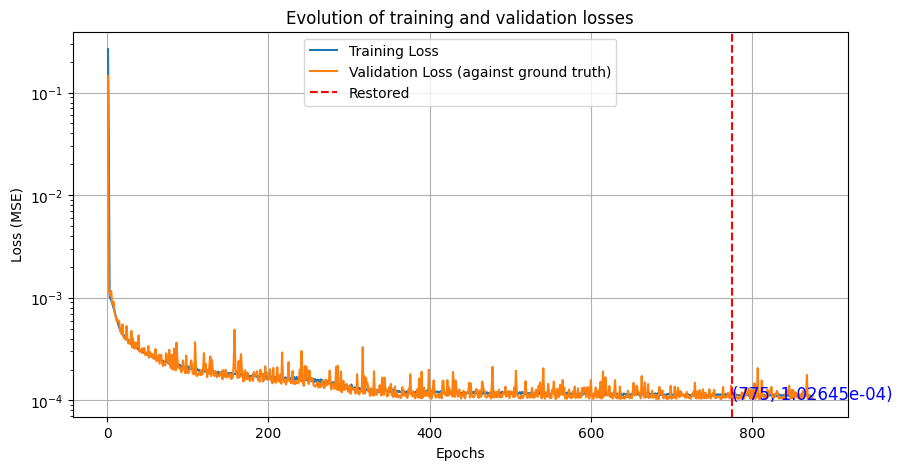

257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 1.0372e-04


0.00010264533921144903

In [10]:
#globals
#------
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 1000
patience = 100
start_from_epoch = 500
loss = "mse"
metrics = []
schedule_tg = 100
opt = Adam(learning_rate=1e-4, weight_decay=1e-2)
batch = 32
model_name = preliminary_model_name
#------

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)
def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath=f'models/punn_{model_name}.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#PUNN
punn_model = Sequential()
punn_model.add(Input(shape=(n_features, ))) #_ for batch dim
punn_model.add(Rescaling(scale=scaler_X.scale_, offset=scaler_X.min_)) #input scaling
for _ in range(0,n_hid_layers):
    punn_model.add(Dense(n_neurons, activation=act))
punn_model.add(Dense(1, activation="linear")) #output layer -> a^
punn_model.add(Rescaling(scale=scaler_Y.scale_, offset=scaler_Y.mean_)) #output denormalization x=x_norm*std+mean

punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#punn_model.summary()
#first column of Y is the label: acceleration
history_punn_fwd = punn_model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val),
                                  batch_size=batch, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_punn_fwd.history, start_from_epoch)
punn_model.evaluate(x=X_val, y=Y_val, batch_size=batch) #just to confirm final validation loss

# PINN (see model definition on models.py)

In [5]:
""" # collocation points
collocation_size = 10000
print("Number of collocation points: " + str(collocation_size))
#dimension size -> ["t", "fv0_u", "fv0_v", "d_fv0_lv", "d*_fv0_lv", "lv_v"]
sampler = qmc.LatinHypercube(d=n_features)
collocation = sampler.random(n=collocation_size)
print(qmc.discrepancy(collocation)) #evaluate sampling distribution
u_min = PHYSICS_PARAMS["a_min"]*PHYSICS_PARAMS["m"]
u_max = PHYSICS_PARAMS["a_max"]*PHYSICS_PARAMS["m"]
v_max = PHYSICS_PARAMS["v_max"]
t_max = collocation_size
l_bounds = [0, u_min, 0.0]
u_bounds = [t_max, u_max, v_max]
print(l_bounds)
print(u_bounds)
X_c = qmc.scale(collocation, l_bounds=l_bounds, u_bounds=u_bounds).astype(np.float32)
pd.DataFrame(X_c).to_csv("data/collocation_data.csv") """
X_c = pd.read_csv("data/collocation_data.csv", index_col=0).to_numpy(dtype=np.float32)
print(X_c)

[[ 8.3653760e+03  3.7568757e+03  1.1240701e+01]
 [ 5.8968926e+03 -8.9770758e+02  8.5112772e+00]
 [ 6.8083945e+03 -3.2430515e+03  1.1903420e+01]
 ...
 [ 1.1078970e+03 -2.4178279e+03  4.9585280e+00]
 [ 4.2721929e+03 -7.6607627e+03  3.0494578e+00]
 [ 1.4977633e+03  3.0954707e+03  5.5947490e+00]]


## Training

Epoch 1/1000


/home/josearteaga/Desktop/tese/PINN-control-platooning/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'pinn_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.3508 - mse: 0.3374 - val_loss: 0.9124 - val_mse: 0.3168 - learning_rate: 1.0000e-04
Epoch 2/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6945 - mse: 0.3124 - val_loss: 0.3545 - val_mse: 0.2926 - learning_rate: 1.0000e-04
Epoch 3/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3017 - mse: 0.2681 - val_loss: 0.2091 - val_mse: 0.2440 - learning_rate: 1.0000e-04
Epoch 4/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1839 - mse: 0.2198 - val_loss: 0.1340 - val_mse: 0.1743 - learning_rate: 1.0000e-04
Epoch 5/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1185 - mse: 0.1545 - val_loss: 0.0753 - val_mse: 0.0905 - learning_rate: 1.0000e-04
Epoch 6/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0628 - mse: 0.0701 - val_loss: 0.0356 - val_mse: 0.0304 - learning_rate: 1.0000e-04
Epoch 7/1000
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0293 - mse: 0.0224 - val_loss: 0.0177 - val_mse: 0.0108 - lea

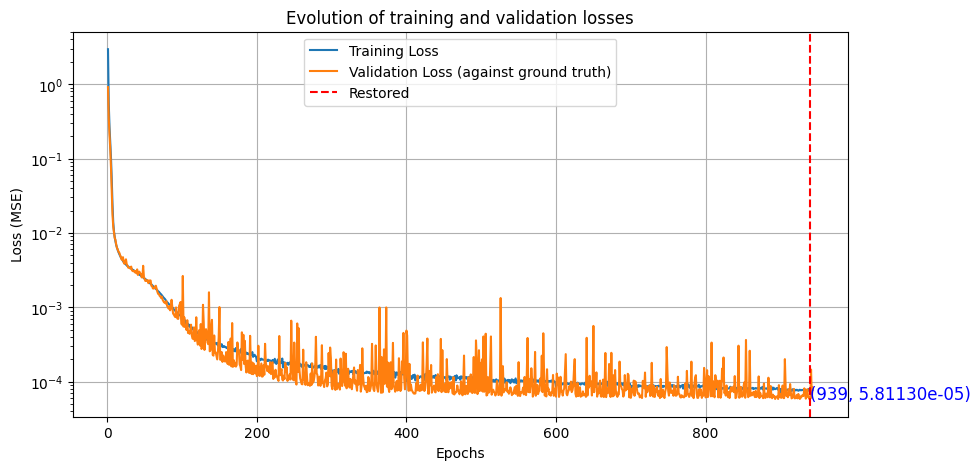

In [9]:
#globals
#------
n_features = X.shape[1]
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 1000
patience = 100
start_from_epoch = 100
schedule_tg = 100
metrics = ["mse"]
opt = Adam(learning_rate=1e-4, weight_decay=1e-2)
batch = 32
alpha = 0.5 #physics weight = 1-alpha
model_name = preliminary_model_name + f"_alpha{alpha}_features{n_features}"
true_phy_params = { #copied from above
        #*constant
        "g": PHYSICS_PARAMS["g"],
        "m": PHYSICS_PARAMS["m"], #kg toyota prius 2001 curb weight (fixed weight)
        # https://en.wikipedia.org/wiki/Automobile_drag_coefficient
        "Af": PHYSICS_PARAMS["Af"], # car cross sectional area
        "Cd": PHYSICS_PARAMS["Cd"], #toyota prius 2001
        #*variable
        #rolling resistance:
        "c0": PHYSICS_PARAMS["c0"],
        "c1": PHYSICS_PARAMS["c1"],
        "p": PHYSICS_PARAMS["p"], #average air density
        "road_grade": PHYSICS_PARAMS["road_grade"]
    }
#train_params = {"m": 1000, "Af": 2.5, "Cd": 0.2} #if joint training provide initial values
train_params = {}
#------

# callbacks
early_stopping = EarlyStopping(monitor='val_mse', patience=patience,
                            restore_best_weights=True, start_from_epoch=start_from_epoch)

def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

custom_weight_logger = CustomWeightLog()

checkpoint = ModelCheckpoint(
filepath=f'models/pinn_{model_name}.keras',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
verbose=0)

callbacks = [early_stopping, lr_scheduler, checkpoint]

pinn_model = PinnModel(true_phy_params, train_params, n_hid_layers, n_neurons,
                       scalerX_params={"min": scaler_X.min_, "scale": scaler_X.scale_}, 
                       scalerY_params={"mean": scaler_Y.mean_, "scale": scaler_Y.scale_}, act=act)
#Custom PINN loss
loss = CombinedLoss(model=pinn_model, X_c=X_c, alpha=alpha)
pinn_model.build(input_shape=(None, n_features)) #none -> batch dim, defined later when fitting
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)

#training (SCALING NOW HANDLED INTERNALLY)
history_pinn_fwd = pinn_model.fit(x=X_train, y=Y_train,
                                validation_data=(X_val, Y_val), #validating against true values here, not measurements
                                batch_size=batch, epochs=epochs,
                                callbacks=callbacks)
loss_plot(history_pinn_fwd.history, start_from_epoch)
#pinn_model.summary()


# PUNN vs PINN

## test driving cycle

TRAJECTORY us06col statistics: 
PUNN:
MSE/RMSE for acceleration: 3.98453e-05, 6.31231e-03
MSE/RMSE for velocity: 1.75105e+00, 1.32327e+00
MSE/RMSE for position: 6.45805e+02, 2.54127e+01
PINN:
MSE/RMSE for acceleration: 1.71219e-04, 1.30851e-02
MSE/RMSE for velocity: 1.92926e+00, 1.38898e+00
MSE/RMSE for position: 7.10381e+02, 2.66530e+01


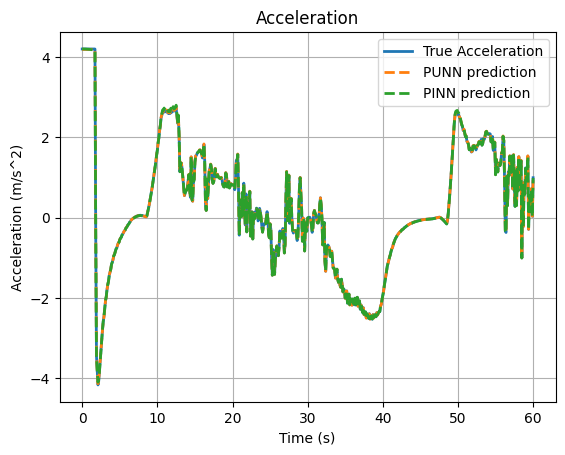

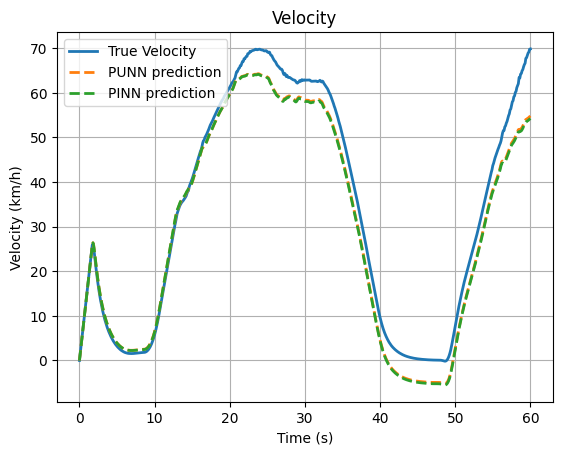

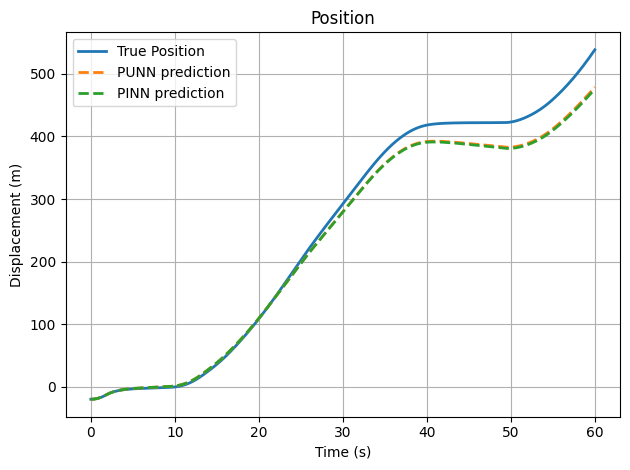

In [11]:
test_trajs = ['us06col']
punn_model = load_model(f"models/punn_FC_noWindow_udds_hwycol_nycccol_70%.keras", compile=False)  # Load model just for prediction
#Load custom pinn model
custom_objects = {"PinnModel": PinnModel}
pinn_model = load_model(f"models/pinn_FC_noWindow_udds_hwycol_nycccol_70%_alpha0.5_features3.keras",
                         custom_objects=custom_objects, compile=False)

for test_traj in test_trajs:

    df = pd.read_csv("data/driving_cycles/CACC_" + test_traj + ".csv")


    t_start = 0
    t_end = 60 #seconds
    idx_start = int(t_start/dt)
    idx_end = int(t_end/dt)+1
    mask = (df["t"] >= t_start) & (df["t"] <= t_end) #trim data to specific segment: prevents integration error. More zoom also
    eval_Y = df[mask][["fv0_a", "fv0_v", "fv0_x"]].to_numpy()
    eval_X = df[mask][["t", "fv0_u", "fv0_v_noise"]].to_numpy()
    t_eval = df[mask][["t"]].to_numpy()

    print("TRAJECTORY " + str(test_traj) + " statistics: ")
    print("PUNN:")
    punn_test_eval = evaluate_results(model=punn_model, X=eval_X, true_data=eval_Y, dt=dt)
    print("PINN:")
    pinn_test_eval = evaluate_results(model=pinn_model, X=eval_X, true_data=eval_Y, dt=dt)
    comparison_plot(t=t_eval, true_data=eval_Y, meas_data=None,
        pred_data=[(punn_test_eval, "PUNN prediction"), (pinn_test_eval, "PINN prediction")],
        suptitle="Predicted solution vs Ground Truth: PUNN vs PINN for trajectory " + str(traj_id)
    )

## all driving cycles

Trajectory (CACC_us06col) statistics: 
PUNN:
MSE/RMSE for acceleration: 9.09944e-05, 9.53910e-03
MSE/RMSE for velocity: 7.27606e-02, 2.69742e-01
MSE/RMSE for position: 2.84668e+00, 1.68721e+00
PINN:
MSE/RMSE for acceleration: 1.99259e-04, 1.41159e-02
MSE/RMSE for velocity: 1.08350e-01, 3.29166e-01
MSE/RMSE for position: 1.49834e+00, 1.22407e+00
----


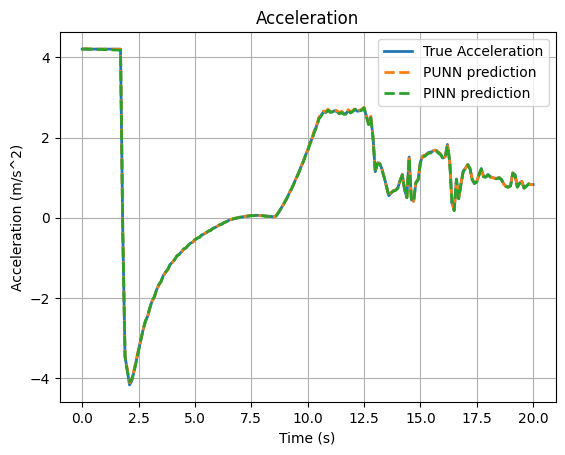

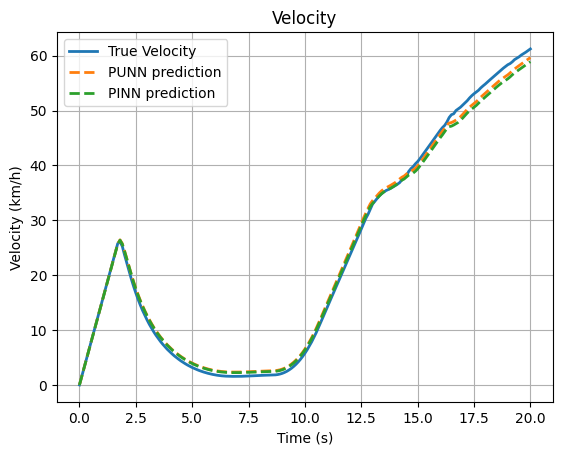

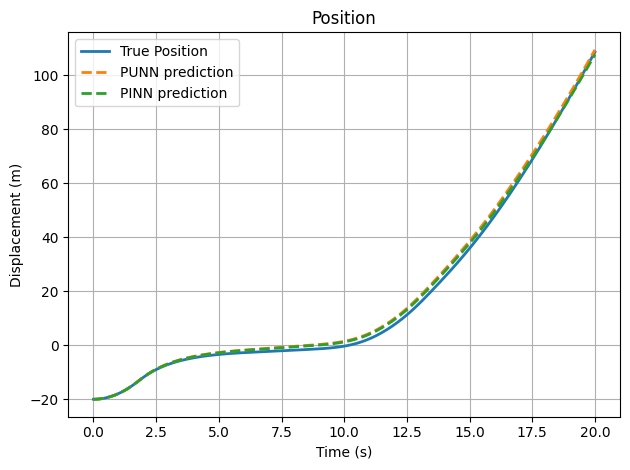

Trajectory (CACC_hwycol) statistics: 
PUNN:
MSE/RMSE for acceleration: 4.35844e-05, 6.60185e-03
MSE/RMSE for velocity: 8.14999e-03, 9.02773e-02
MSE/RMSE for position: 9.33561e-02, 3.05542e-01
PINN:
MSE/RMSE for acceleration: 1.77407e-04, 1.33194e-02
MSE/RMSE for velocity: 2.78055e-02, 1.66750e-01
MSE/RMSE for position: 7.50285e-01, 8.66190e-01
----


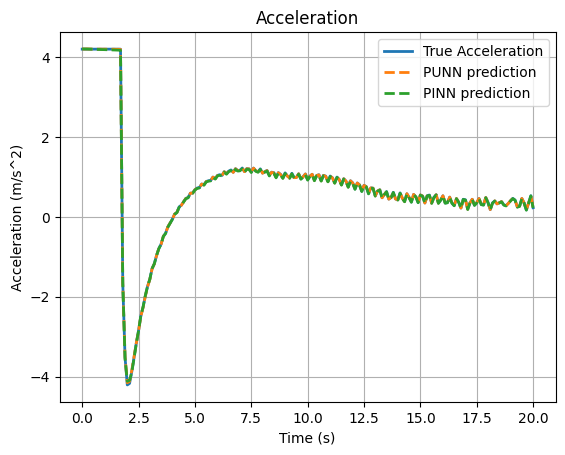

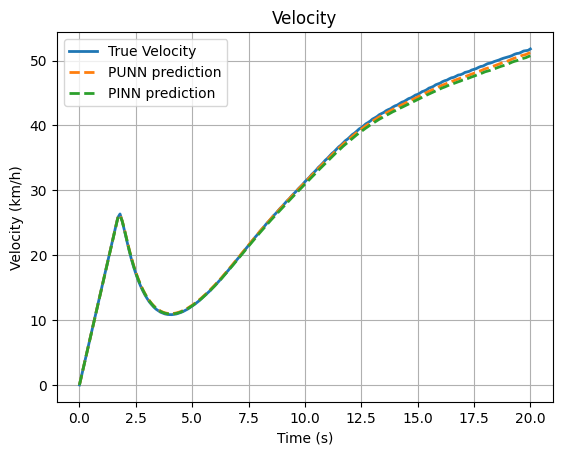

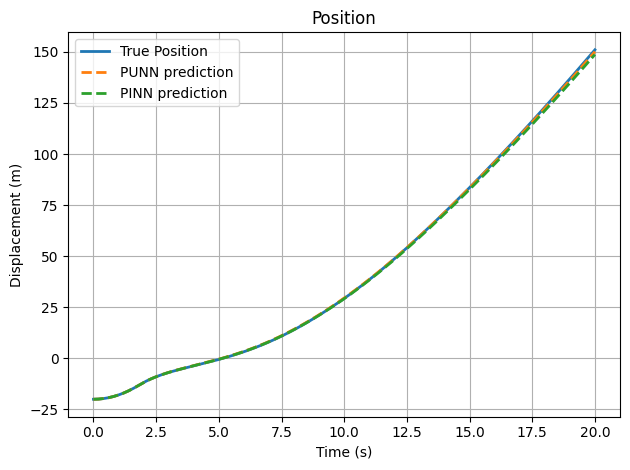

Trajectory (CACC_nycccol) statistics: 
PUNN:
MSE/RMSE for acceleration: 3.26630e-05, 5.71515e-03
MSE/RMSE for velocity: 7.34938e-02, 2.71097e-01
MSE/RMSE for position: 8.12574e+00, 2.85057e+00
PINN:
MSE/RMSE for acceleration: 5.88199e-05, 7.66941e-03
MSE/RMSE for velocity: 5.26287e-02, 2.29409e-01
MSE/RMSE for position: 6.08748e+00, 2.46728e+00
----


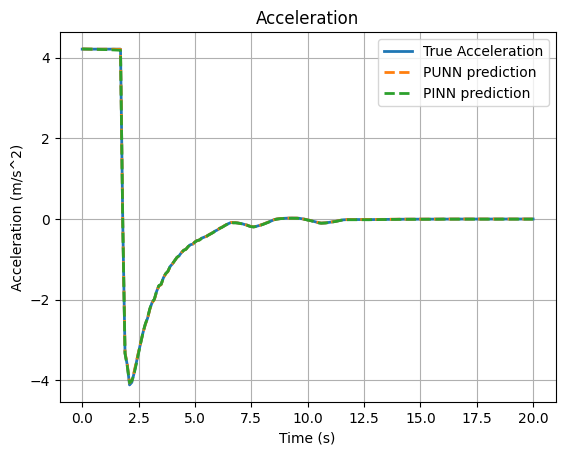

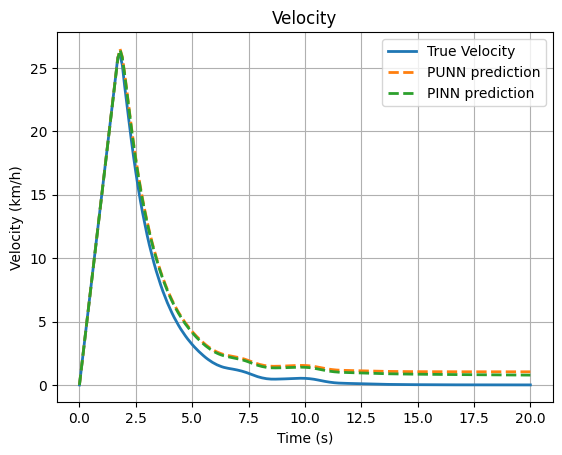

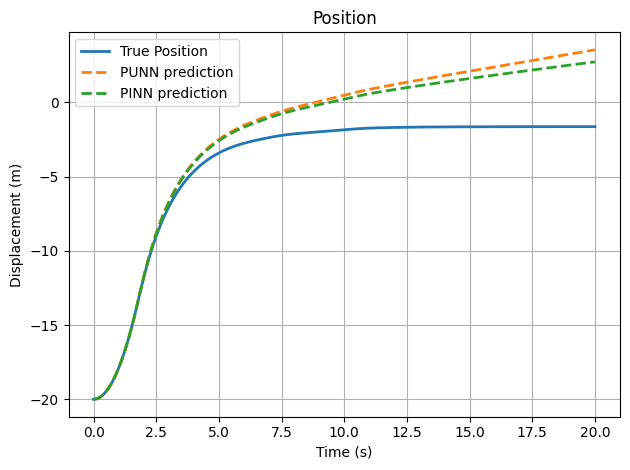

Trajectory (CACC_udds) statistics: 
PUNN:
MSE/RMSE for acceleration: 3.28045e-05, 5.72753e-03
MSE/RMSE for velocity: 7.28760e-02, 2.69956e-01
MSE/RMSE for position: 8.06949e+00, 2.84069e+00
PINN:
MSE/RMSE for acceleration: 5.97610e-05, 7.73052e-03
MSE/RMSE for velocity: 5.23893e-02, 2.28887e-01
MSE/RMSE for position: 6.06988e+00, 2.46371e+00
----


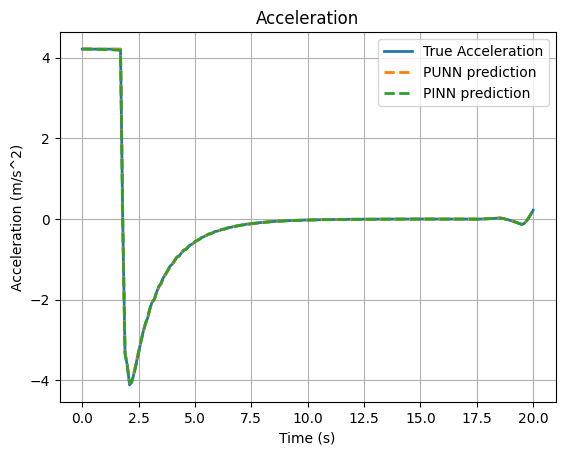

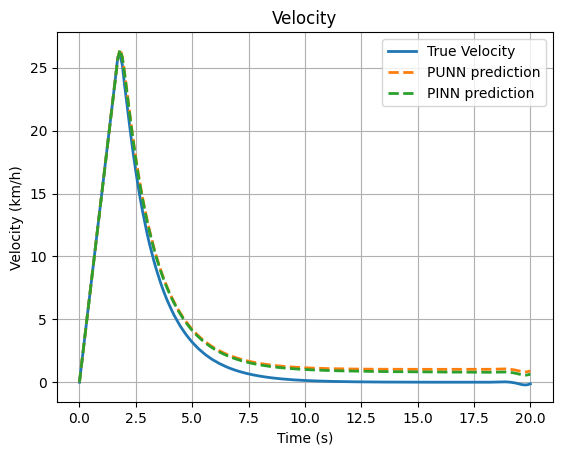

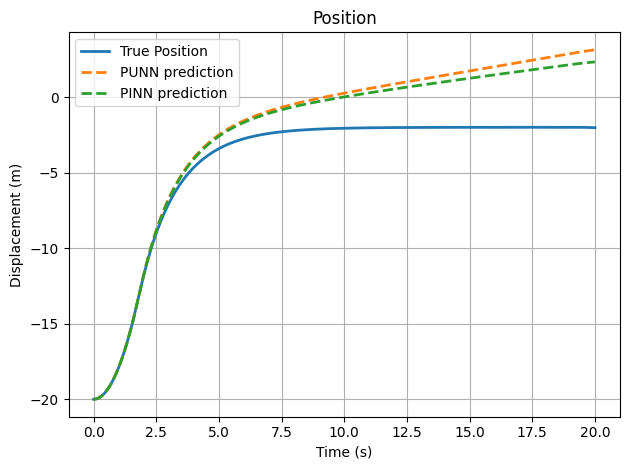

In [6]:
#*TESTING 
# Directory containing other driving cycles
driving_cycles_dir = "data/driving_cycles"
cycle_files = [f for f in os.listdir(driving_cycles_dir) if f.endswith(".csv")]

for cycle_file in cycle_files:
    traj_id = os.path.splitext(cycle_file)[0]
    df_test = pd.read_csv(os.path.join(driving_cycles_dir, cycle_file))
    
    t_start = 0
    t_end = 20 #seconds
    idx_start = int(t_start/dt)
    idx_end = int(t_end/dt)+1
    mask = (df_test["t"] >= t_start) & (df_test["t"] <= t_end)
    eval_Y = df_test[mask][["fv0_a", "fv0_v", "fv0_x"]].to_numpy()
    eval_X = df_test[mask][["t", "fv0_u", "fv0_v_noise"]].to_numpy()
    t_eval = df_test[mask][["t"]].to_numpy()

    print("Trajectory (" + str(traj_id) + ") statistics: ")
    print("PUNN:")
    punn_test_eval = evaluate_results(model=punn_model, X=eval_X, true_data=eval_Y, dt=dt)
    print("PINN:")
    pinn_test_eval = evaluate_results(model=pinn_model, X=eval_X, true_data=eval_Y, dt=dt)
    print("----")
    comparison_plot(t=t_eval, true_data=eval_Y, meas_data=None,
        pred_data=[(punn_test_eval, "PUNN prediction"), (pinn_test_eval, "PINN prediction")],
        suptitle="Predicted solution vs Ground Truth: PUNN vs PINN for trajectory " + str(traj_id)
    )

# Convert to ONNX

In [12]:
custom_objects = {"PinnModel": PinnModel}
model = load_model(f"models/pinn_FC_noWindow_udds_hwycol_nycccol_70%_alpha0.5_features3.keras",
                   custom_objects=custom_objects, compile=False)
opt = Adam(learning_rate=1e-4, weight_decay=1e-2)
print(model(np.zeros((1,3))))
#model.compile(optimizer=opt, loss=loss, metrics=metrics)
#model.evaluate(x=X_val_norm, y=Y_val_norm, batch_size=batch) #just to confirm final validation loss
model_input_signature = [
    tf.TensorSpec(shape=(1, n_features), dtype=tf.float32),
]

model.output_names = ['output'] #had to add this to prevent error.
onnx_model, _ = tf2onnx.convert.from_keras(model,
    output_path='models/onnx/pinn_FC_noWindow_udds_hwycol_nycccol_70%_alpha0.5_features3.onnx',
    input_signature=model_input_signature,
)

tf.Tensor([[-0.27009597]], shape=(1, 1), dtype=float32)


I0000 00:00:1751732313.938692 1924514 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1751732313.938765 1924514 single_machine.cc:374] Starting new session
I0000 00:00:1751732313.943321 1924514 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5708 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1751732313.971826 1924514 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5708 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1751732313.975936 1924514 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1751732313.975996 1924514 single_machine.cc:374] Starting new session
I0000 00:00:1751732313.980584 1924514 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/devic

or convert to savedmodel then to onnx... (NOT WORKING, gives shape mismatch when running in CASadi)

In [ ]:
#tf.saved_model.save(model, 'models/saved_model/pinn_FC_noWindow_udds_hwycol_nycccol_70%_alpha0.5_features3')

""" !python -m tf2onnx.convert \
    --saved-model "models/saved_model/pinn_FC_noWindow_udds_hwycol_nycccol_70%_alpha0.5_features3" \
    --output "models/onnx/pinn_FC_noWindow_udds_hwycol_nycccol_70%_alpha0.5_features3.onnx" \
    --verbose  """

E0000 00:00:1751625627.231242 1455923 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751625627.234312 1455923 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751625627.243018 1455923 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751625627.243076 1455923 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751625627.243079 1455923 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751625627.243080 1455923 computation_placer.cc:177] computation placer already registered. Please check linka